In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import uniform, expon, lognorm, weibull_min, chi2, wasserstein_distance
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

### Distributions of the independent components

In [2]:
rvs = [uniform(), expon(scale=0.1), lognorm(s=1), weibull_min(c=2), chi2(df=4)]

In [3]:
def sample_normed(n, rv):
    return (rv.rvs(size=n) - rv.mean()) / rv.std()

In [4]:
n = 5000
eps = np.zeros((n,len(rvs)))
for i, rv in enumerate(rvs):
    eps[:,i] = sample_normed(n,rv)

In [5]:
# 1-Wasserstein metric between empirical distributions

def wasserstein_dist(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D = np.zeros((p1,p2))
    for i in range(p1):
        for j in range(p2):
            D[i,j] = wasserstein_distance(X1[:,i],X2[:,j]) 
    return D

In [6]:
wasserstein_dist(eps,eps)

array([[0.        , 0.38921544, 0.54592901, 0.16778936, 0.29614438],
       [0.38921544, 0.        , 0.21080314, 0.22343086, 0.09429819],
       [0.54592901, 0.21080314, 0.        , 0.39539265, 0.27791159],
       [0.16778936, 0.22343086, 0.39539265, 0.        , 0.13050269],
       [0.29614438, 0.09429819, 0.27791159, 0.13050269, 0.        ]])

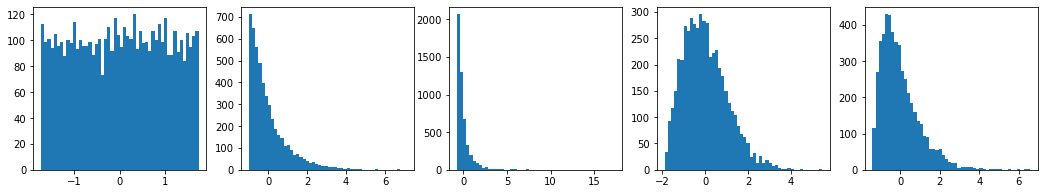

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Create synthetic observations

In [8]:
nlat = 5
joint_latents = [0,1]
env1_specific = [2]
env2_specific = [3]
env3_specific = [4]
d1 = 10
d2 = 11
d3 = 12
n1 = 5000
n2 = 4000
n3 = 4500

env1_latents = joint_latents + env1_specific
env2_latents = joint_latents + env2_specific
env3_latents = joint_latents + env3_specific

In [9]:
def matrix_from_normal(shape, mu=0, sigma=1):
    A = np.random.normal(loc=mu, scale=sigma, size=shape)
    return A

In [10]:
# Sample entries of G1
#np.random.seed(101)
G1 = matrix_from_normal(shape=(d1,len(env1_latents)))
G1

array([[-0.31980979, -1.11511014,  1.33571174],
       [ 2.10299235,  0.69270297, -0.03957043],
       [-1.17679026,  0.29944933,  0.49463072],
       [ 1.0544263 , -0.71889627, -1.43717822],
       [-1.05490271,  0.72034815, -0.45713677],
       [ 0.05340381, -0.03330085, -0.41650401],
       [-1.34569216,  0.64897312,  1.0051948 ],
       [-0.32108311,  0.08612441,  2.04675541],
       [-1.06814861,  0.38463232, -0.83668086],
       [ 0.76245276,  1.10203835, -0.63028088]])

In [11]:
# G2 and G3
#np.random.seed(102)
G2 = matrix_from_normal(shape=(d2,len(env2_latents)))

#np.random.seed(103)
G3 = matrix_from_normal(shape=(d3,len(env3_latents)))

In [12]:
def sample(n, mixing, rvs):
    nr_comps = len(rvs)
    eps = np.zeros((n,nr_comps))
    for i, rv in enumerate(rvs):
        eps[:,i] = sample_normed(n,rv)
    X = np.matmul(mixing, np.transpose(eps))
    return(X)

In [13]:
# Create synthetic data (uncoupled!!)
X1 = sample(n1, G1, [rvs[i] for i in env1_latents])
X2 = sample(n2, G2, [rvs[i] for i in env2_latents])
X3 = sample(n3, G3, [rvs[i] for i in env3_latents])

### Apply linear ICA to recover the (empirical) distribution of the sources

In [14]:
def rescale_columns(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()
    return X

# X1 has shape p x n
def get_sources(X, seed=101):
    cov = np.cov(X)
    rk = np.linalg.matrix_rank(cov)
    print("Rank:", rk)
    
    ICA = FastICA(n_components=rk, random_state=seed, whiten='unit-variance', max_iter=1000) 
    ICA.fit(np.transpose(X))
    print("Iterations:", ICA.n_iter_)
    eps = ICA.transform(np.transpose(X))
    scaling = eps.std(axis=0)
    
    eps = rescale_columns(eps)
    mixing = np.matmul(ICA.mixing_, np.diag(scaling))    
    
    return eps, mixing

In [15]:
eps1, mixing1 = get_sources(X1)

Rank: 3
Iterations: 6


In [16]:
mixing1

array([[-0.29355655, -1.30340627, -1.11723708],
       [ 2.10062467,  0.06522474,  0.71323856],
       [-1.18800056, -0.49514207,  0.29780927],
       [ 1.07016662,  1.40944294, -0.72911727],
       [-1.07766752,  0.43194026,  0.71609715],
       [ 0.05286781,  0.40549879, -0.03641796],
       [-1.36325984, -0.99321107,  0.6532418 ],
       [-0.31717759, -1.99347511,  0.1003326 ],
       [-1.0854139 ,  0.80040125,  0.37433958],
       [ 0.74163732,  0.62316899,  1.11250162]])

In [17]:
eps2, mixing2 = get_sources(X2, seed=102)

Rank: 3
Iterations: 6


In [18]:
eps3, mixing3 = get_sources(X3, seed=103)

Rank: 3
Iterations: 3


In [19]:
# Collect results
indep_comps = [eps1, eps2, eps3]
mixings = [mixing1, mixing2, mixing3]

### Plot recovered distributions

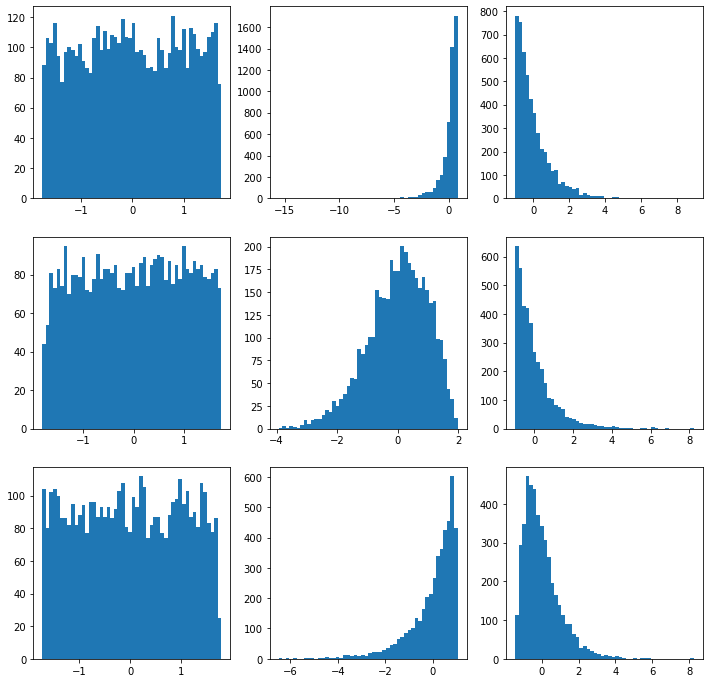

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax[i,j].hist(indep_comps[i][:,j], bins=50)

plt.show()

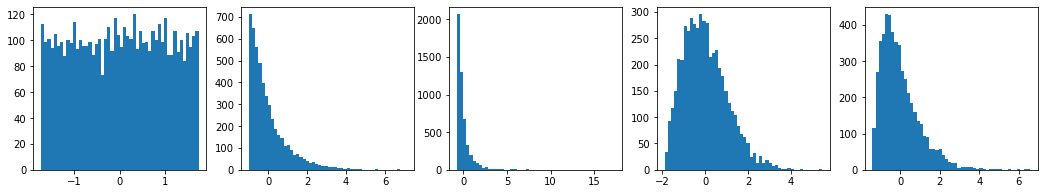

In [24]:
# Compare with "true" distributions

fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Matching

In [25]:
def wasserstein_dist_signed(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            D_large[i,j] = wasserstein_distance(X1[:,i],X2_large[:,j]) 
    D = np.zeros((p1,p2))
    for i in range(p2):
        D[:,i] = D_large[:,[i,i+p2]].min(axis=1)
    return D

In [26]:
def minimum_matching(D):
    p1, p2 = D.shape
    matching = {}
    for i in range(p1):
        row_argmin = D[i,:].argmin()
        if D[:,row_argmin].argmin() == i:
            matching[i] = row_argmin
    return matching

In [27]:
D12 = wasserstein_dist_signed(eps1,eps2)
D12.round(3)

array([[0.015, 0.156, 0.387],
       [0.528, 0.386, 0.186],
       [0.376, 0.236, 0.016]])

In [28]:
minimum_matching(D12)

{0: 0, 2: 2}

In [29]:
D13 = wasserstein_dist_signed(eps1,eps3)
D13.round(3)

array([[0.011, 0.38 , 0.287],
       [0.535, 0.203, 0.266],
       [0.387, 0.018, 0.098]])

In [30]:
minimum_matching(D13)

{0: 0, 2: 1}

In [31]:
D23 = wasserstein_dist_signed(eps2,eps3)
D23.round(3)

array([[0.013, 0.372, 0.28 ],
       [0.16 , 0.233, 0.14 ],
       [0.39 , 0.021, 0.102]])

In [32]:
minimum_matching(D23)

{0: 0, 2: 1}

In [33]:
# Definition of a joint factor:
# A collection of distributions of size |E| such that 
# - all distibutions within that joint factor match

In [34]:
def is_consistent(f, matchings):
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if f[i] not in list(matchings[str(i)+str(j)].keys()):
                return False
            if matchings[str(i)+str(j)][f[i]] != f[j]:
                return False
    return True



def get_joint_factors(indep_comps):
    
    nr_env = len(indep_comps)
    
    matchings = {}
    for i in range(nr_env):
        for j in range(i+1, nr_env):
            D = wasserstein_dist_signed(indep_comps[i],indep_comps[j])
            matchings[str(i)+str(j)] = minimum_matching(D)
    
    # Define potential factors
    pot_factors = [[i] for i in list(matchings['01'].keys())] 
    for f in pot_factors:
        for i in range(1,nr_env):
            if f[0] not in list(matchings['0'+str(i)].keys()):
                continue
            else:
                f.append(matchings['0'+str(i)][f[0]])
    pot_factors = [f for f in pot_factors if len(f)==nr_env]
    
    # Only keep consistent factors
    factors = [f for f in pot_factors if is_consistent(f, matchings)]
    
    return(factors)

In [35]:
joint_factors = get_joint_factors(indep_comps)
joint_factors

# Interpretation:
# We match the following recovered components:
# component 0 of domain 1 WITH component 0 of domain 2 WITH component 2 of domain 3

[[0, 0, 0], [2, 2, 1]]

### Recover joint mixing matrix

In [36]:
def matching_sign(distr1, distr2):
        normal_dist = wasserstein_distance(distr1,distr2) 
        flipped_dist = wasserstein_distance(distr1,-distr2)
        if normal_dist <= flipped_dist:
            return 1
        else:
            return -1 

In [37]:
def add_signs_to_factor(f, indep_comps):
    
    signs = [1]
    
    for i in range(1,len(f)):
        signs.append(matching_sign(indep_comps[0][:,f[0]], indep_comps[i][:,f[i]]))
         
    # Check for consistency
    for i in range(1, len(f)):
        for j in range(i+1, len(f)):
            if signs[i]*signs[j] != matching_sign(indep_comps[i][:,f[i]], indep_comps[j][:,f[j]]):
                raise ValueError("Signs are not consistent: ", i, j)
    return signs

In [38]:
joint_factor_signs = [add_signs_to_factor(f, indep_comps) for f in joint_factors]
joint_factor_signs

[[1, 1, 1], [1, 1, -1]]

In [39]:
def joint_mixing_matrix(mixings, joint_factors, joint_factor_signs):
    
    nr_env = len(mixings)
    nr_joint = len(joint_factors)
    total_nr_obs = sum([M.shape[0] for M in mixings])
    total_nr_lat = sum([M.shape[1]-nr_joint for M in mixings]) + nr_joint
    M_large = np.zeros((total_nr_obs, total_nr_lat))
    
    # Joint columns
    for i,f in enumerate(joint_factors):
        current_row = 0
        for env in range(nr_env):
            col = joint_factor_signs[i][env] * mixings[env][:,f[env]]
            M_large[np.ix_(np.arange(current_row,(current_row+len(col))),np.array([i]))] \
            = col.reshape((len(col),1))
            current_row = current_row + len(col)
    
    # Domain-specific columns
    current_col = len(joint_factors)
    current_row = 0
    for env in range(nr_env):
        M = mixings[env]
        nrows, ncols = M.shape
        joint_cols = [f[env] for f in joint_factors]
        domain_spec_cols = set(np.arange(ncols)) - set(joint_cols)
        for i, col in enumerate(domain_spec_cols):
            M_large[np.ix_(np.arange(current_row,(current_row+nrows)),np.array([current_col+i]))] \
            = M[:,col].reshape((nrows,1))
        current_col = current_col + len(domain_spec_cols)
        current_row = current_row + nrows
    return(M_large)

In [40]:
joint_mixing_matrix(mixings, joint_factors, joint_factor_signs).round(2)

array([[-0.29, -1.12, -1.3 ,  0.  ,  0.  ],
       [ 2.1 ,  0.71,  0.07,  0.  ,  0.  ],
       [-1.19,  0.3 , -0.5 ,  0.  ,  0.  ],
       [ 1.07, -0.73,  1.41,  0.  ,  0.  ],
       [-1.08,  0.72,  0.43,  0.  ,  0.  ],
       [ 0.05, -0.04,  0.41,  0.  ,  0.  ],
       [-1.36,  0.65, -0.99,  0.  ,  0.  ],
       [-0.32,  0.1 , -1.99,  0.  ,  0.  ],
       [-1.09,  0.37,  0.8 ,  0.  ,  0.  ],
       [ 0.74,  1.11,  0.62,  0.  ,  0.  ],
       [-1.28, -0.34,  0.  ,  1.06,  0.  ],
       [-0.27,  1.44,  0.  ,  0.22,  0.  ],
       [-0.74,  0.72,  0.  , -0.55,  0.  ],
       [-0.61,  1.4 ,  0.  , -0.87,  0.  ],
       [ 0.48, -0.28,  0.  , -0.88,  0.  ],
       [-1.11, -1.07,  0.  , -0.76,  0.  ],
       [ 0.17,  0.5 ,  0.  ,  0.53,  0.  ],
       [-0.61,  0.21,  0.  ,  1.46,  0.  ],
       [-0.55,  1.24,  0.  ,  1.38,  0.  ],
       [ 0.16,  1.06,  0.  ,  1.38,  0.  ],
       [-0.5 , -1.43,  0.  ,  0.9 ,  0.  ],
       [ 1.33, -1.26,  0.  ,  0.  ,  0.8 ],
       [ 0.89, -1.03,  0.  ,  0.

For comparison:

In [41]:
mixing1.round(2)

array([[-0.29, -1.3 , -1.12],
       [ 2.1 ,  0.07,  0.71],
       [-1.19, -0.5 ,  0.3 ],
       [ 1.07,  1.41, -0.73],
       [-1.08,  0.43,  0.72],
       [ 0.05,  0.41, -0.04],
       [-1.36, -0.99,  0.65],
       [-0.32, -1.99,  0.1 ],
       [-1.09,  0.8 ,  0.37],
       [ 0.74,  0.62,  1.11]])

In [42]:
mixing2.round(2)

array([[-1.28,  1.06, -0.34],
       [-0.27,  0.22,  1.44],
       [-0.74, -0.55,  0.72],
       [-0.61, -0.87,  1.4 ],
       [ 0.48, -0.88, -0.28],
       [-1.11, -0.76, -1.07],
       [ 0.17,  0.53,  0.5 ],
       [-0.61,  1.46,  0.21],
       [-0.55,  1.38,  1.24],
       [ 0.16,  1.38,  1.06],
       [-0.5 ,  0.9 , -1.43]])

In [43]:
mixing3.round(2)

array([[ 1.33,  1.26,  0.8 ],
       [ 0.89,  1.03, -0.07],
       [-0.89,  1.04, -0.55],
       [-0.6 , -1.26, -0.81],
       [ 0.97,  0.47,  1.97],
       [-1.16, -0.92, -0.53],
       [ 1.7 ,  0.45, -2.1 ],
       [-0.78,  2.17, -0.18],
       [-1.29,  0.85, -0.17],
       [-0.81,  0.45,  1.62],
       [-0.58, -0.73,  0.08],
       [-2.84, -0.76,  0.33]])

Notes: 
Could sample from "empirical joint distribution" now:
- Have empirical distribution of each independent component (merge the ones for the joint components).
- Sample from the empirical distributions.
- Using the joint mixing matrix, this produces samples of the joint distribution.

Using the joint mixing matrix we can also transport observations in one domain to another.